NFL Big Data Bowl 2022 

Andrew Curtis Project

Effect of weight and height of Kick Returners on Return Yardage

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import numpy as np
from pyspark import SparkContext, SparkFiles
from pyspark.sql import SparkSession
import string
import matplotlib.pyplot as plt
from pyspark.sql.functions import split
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

spark = SparkSession.builder.master("local").appName("NFL").getOrCreate()


In [ ]:
playerData = spark.read.csv('players.csv', header = True)
playData = spark.read.csv('plays.csv', header = True)

Data Pre-processing and Cleaning

In [ ]:
#filter for only kick return plays and non-null returners
returnData = playData.filter(playData.kickReturnYardage != 'NA').filter(playData.returnerId != 'NA').drop("gameId", "playId", "quarter", "possessionTeam", "yardlineSide", "yardlineNumber", "gameClock", "penaltyJerseyNumbers", "preSnapHomeScore", "preSnapVisitorScore", "passResult", "absoluteYardlineNumber")

reducedPlayerData = playerData.drop("birthDate", "collegeName", "Position", "displayName") #data cleaning

returnData = returnData.withColumnRenamed('returnerId', 'nflId') #to match player ID's

#merge data sets
merged3 = returnData.join(reducedPlayerData, returnData.nflId == reducedPlayerData.nflId)
merged3 = merged3.filter(merged3.weight != 'NA').filter(merged3.height != 'NA')
merged3.show(5) 

+--------------------+----+---------+--------------------+------------------+--------+-----+-------------+------------+------------+----------+-----------------+----------+-----+------+------+
|     playDescription|down|yardsToGo|specialTeamsPlayType|specialTeamsResult|kickerId|nflId|kickBlockerId|penaltyCodes|penaltyYards|kickLength|kickReturnYardage|playResult|nflId|height|weight|
+--------------------+----+---------+--------------------+------------------+--------+-----+-------------+------------+------------+----------+-----------------+----------+-----+------+------+
|(9:20) C.Johnston...|   4|        4|                Punt|            Return|   45603|42450|           NA|        UNSd|         -15|        56|                5|        36|42450|  5-10|   192|
|M.Bosher kicks 64...|   0|        0|             Kickoff|            Return|   37267|44979|           NA|          NA|          NA|        64|               30|        34|44979|  5-11|   191|
|M.Bosher kicks 68...|   0|        

In [ ]:
#pre-processing for height and weight
new_height = merged3.withColumn("height_feet", split(col("height"), "-").getItem(0)).withColumn("height_inch", split(col("height"), "-").getItem(1))
new_height = new_height.withColumn("height_feet", new_height["height_feet"].cast(IntegerType()))
new_height = new_height.withColumn("height_inch", new_height["height_inch"].cast(IntegerType()))
new_height = new_height.withColumn("weight", new_height["weight"].cast(IntegerType()))
new_height = new_height.withColumn("kickReturnYardage", new_height["kickReturnYardage"].cast(IntegerType()))

new_height.show(5)

+--------------------+----+---------+--------------------+------------------+--------+-----+-------------+------------+------------+----------+-----------------+----------+-----+------+------+-----------+-----------+
|     playDescription|down|yardsToGo|specialTeamsPlayType|specialTeamsResult|kickerId|nflId|kickBlockerId|penaltyCodes|penaltyYards|kickLength|kickReturnYardage|playResult|nflId|height|weight|height_feet|height_inch|
+--------------------+----+---------+--------------------+------------------+--------+-----+-------------+------------+------------+----------+-----------------+----------+-----+------+------+-----------+-----------+
|(9:20) C.Johnston...|   4|        4|                Punt|            Return|   45603|42450|           NA|        UNSd|         -15|        56|                5|        36|42450|  5-10|   192|          5|         10|
|M.Bosher kicks 64...|   0|        0|             Kickoff|            Return|   37267|44979|           NA|          NA|          NA|

In [ ]:
#more height and weight pre-processing
new_height = new_height.replace(4, 48, "height_feet")
new_height = new_height.replace(5, 60, "height_feet")
new_height = new_height.replace(6, 72, "height_feet")
new_height = new_height.replace(7, 84, "height_feet")
new_height = new_height.na.fill(value=0, subset=["height_inch"])

#final cleaned data for use
fixedData = new_height.withColumn("totalHeight", col("height_feet")+col("height_inch"))
fixedData.show(10)


+--------------------+----+---------+--------------------+------------------+--------+-----+-------------+------------+------------+----------+-----------------+----------+-----+------+------+-----------+-----------+-----------+
|     playDescription|down|yardsToGo|specialTeamsPlayType|specialTeamsResult|kickerId|nflId|kickBlockerId|penaltyCodes|penaltyYards|kickLength|kickReturnYardage|playResult|nflId|height|weight|height_feet|height_inch|totalHeight|
+--------------------+----+---------+--------------------+------------------+--------+-----+-------------+------------+------------+----------+-----------------+----------+-----+------+------+-----------+-----------+-----------+
|(9:20) C.Johnston...|   4|        4|                Punt|            Return|   45603|42450|           NA|        UNSd|         -15|        56|                5|        36|42450|  5-10|   192|         60|         10|         70|
|M.Bosher kicks 64...|   0|        0|             Kickoff|            Return|   3726

In [ ]:
#unused dataframe with just relavent data, for display purposes
#returnYardsHeight = fixedData.drop("playDescription", "down", "yardsToGo", "specialTeamsPlayType", "specialTeamsResult", "kickerId", "nflId", "kickBlockerId", "penaltyCodes", "penaltyYards", "kickLength", "playResult", "height", "weight", "height_feet", "height_inch")

Linear Regression Models

In [ ]:
#multiple linear regression model
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['weight', 'totalHeight'], outputCol = 'features')
regression_df = vectorAssembler.transform(fixedData)
regression_df = regression_df.select(['features', 'kickReturnYardage'])
regression_df.show(3)

+------------+-----------------+
|    features|kickReturnYardage|
+------------+-----------------+
|[192.0,70.0]|                5|
|[191.0,71.0]|               30|
|[191.0,71.0]|               13|
+------------+-----------------+
only showing top 3 rows



In [ ]:
#multiple linear regression results
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='kickReturnYardage', regParam=0.3)
lr_model = lr.fit(regression_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.08397409895134514,-0.17272287577814582]
Intercept: 12.158473324404788


In [ ]:
#multiple linear regression R**2
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 13.007124
r2: 0.008557


In [ ]:
#information regarding kick returns in data set
regression_df.describe().show()

+-------+------------------+
|summary| kickReturnYardage|
+-------+------------------+
|  count|              5187|
|   mean|16.317524580682477|
| stddev|13.064393287328304|
|    min|               -14|
|    max|               104|
+-------+------------------+



In [ ]:
#simple linear regression with weight model
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['weight'], outputCol = 'features2')
regression_df2 = vectorAssembler.transform(fixedData)
regression_df2 = regression_df2.select(['features2', 'kickReturnYardage'])
regression_df2.show(3)

+---------+-----------------+
|features2|kickReturnYardage|
+---------+-----------------+
|  [192.0]|                5|
|  [191.0]|               30|
|  [191.0]|               13|
+---------+-----------------+
only showing top 3 rows



In [ ]:
#weight linear regression results
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features2', labelCol='kickReturnYardage')
lr_model = lr.fit(regression_df2)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.07245394743687233]
Intercept: 2.2453392762245694


In [ ]:
#weight linear regression r**2
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 13.011266
r2: 0.007925


In [ ]:
#simple linear regression using height model
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['totalHeight'], outputCol = 'features3')
regression_df3 = vectorAssembler.transform(fixedData)
regression_df3 = regression_df3.select(['features3', 'kickReturnYardage'])
regression_df3.show(3)

+---------+-----------------+
|features3|kickReturnYardage|
+---------+-----------------+
|   [70.0]|                5|
|   [71.0]|               30|
|   [71.0]|               13|
+---------+-----------------+
only showing top 3 rows



In [ ]:
#height linear regression results
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features3', labelCol='kickReturnYardage')
lr_model = lr.fit(regression_df3)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.19897782065751088]
Intercept: 2.3199508510968885


In [ ]:
#height linear regression r**2
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 13.056337
r2: 0.001040


Plotting

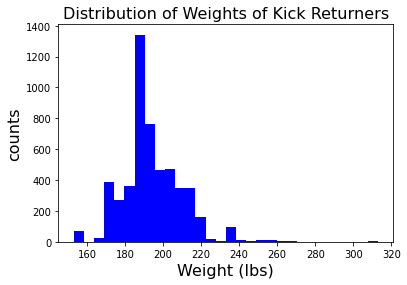

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

#plot for distribution of weights

x = np.array(fixedData.select('weight').collect())
x = x[np.logical_not(np.isnan(x))]

y = np.array(fixedData.select('kickReturnYardage').collect())
y = y[np.logical_not(np.isnan(y))]

# Calculate the point density
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
# idx = z.argsort()
# x, y, z = x[idx], y[idx], z[idx]

plt.hist(x, bins =30, color = 'blue')
plt.xlabel('Weight (lbs)', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.title('Distribution of Weights of Kick Returners', fontsize=16)
plt.show()

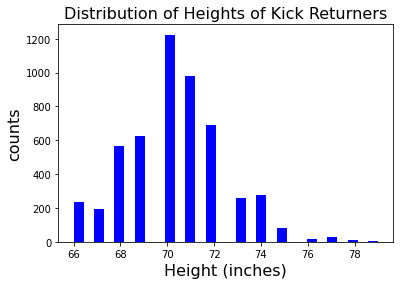

In [ ]:
#plot for distribution of heights
x = np.array(fixedData.select('totalHeight').collect())
x = x[np.logical_not(np.isnan(x))]

y = np.array(fixedData.select('kickReturnYardage').collect())
y = y[np.logical_not(np.isnan(y))]

# Calculate the point density
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
# idx = z.argsort()
# x, y, z = x[idx], y[idx], z[idx]

plt.hist(x, bins =30, color = 'blue')
plt.xlabel('Height (inches)', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.title('Distribution of Heights of Kick Returners', fontsize=16)
plt.show()

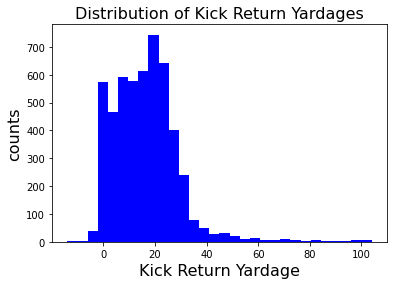

In [ ]:
#plot for distribution of kick return yardages
x = np.array(fixedData.select('weight').collect())
x = x[np.logical_not(np.isnan(x))]

y = np.array(fixedData.select('kickReturnYardage').collect())
y = y[np.logical_not(np.isnan(y))]

# Calculate the point density
# xy = np.vstack([x,y])
# z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
# idx = z.argsort()
# x, y, z = x[idx], y[idx], z[idx]

plt.hist(y, bins =30, color = 'blue')
plt.xlabel('Kick Return Yardage', fontsize=16)
plt.ylabel('counts', fontsize=16)
plt.title('Distribution of Kick Return Yardages', fontsize=16)
plt.show()

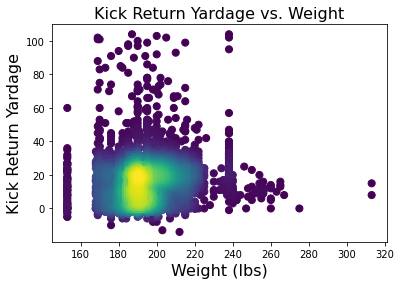

In [ ]:
#density plot of kick return yardage vs weight
x = np.array(fixedData.select('weight').collect())
x = x[np.logical_not(np.isnan(x))]

y = np.array(fixedData.select('kickReturnYardage').collect())
y = y[np.logical_not(np.isnan(y))]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
plt.xlabel('Weight (lbs)', fontsize=16)
plt.ylabel('Kick Return Yardage', fontsize=16)
plt.title('Kick Return Yardage vs. Weight', fontsize=16)
plt.show()

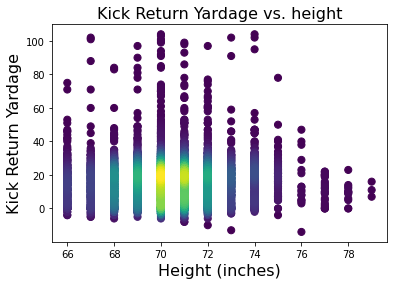

In [ ]:
#density plot of kick return yardage vs height
x = np.array(fixedData.select('totalHeight').collect())
x = x[np.logical_not(np.isnan(x))]

y = np.array(fixedData.select('kickReturnYardage').collect())
y = y[np.logical_not(np.isnan(y))]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
plt.xlabel('Height (inches)', fontsize=16)
plt.ylabel('Kick Return Yardage', fontsize=16)
plt.title('Kick Return Yardage vs. height', fontsize=16)
plt.show()